<a href="https://colab.research.google.com/github/skwolvie/Chess.com-Project/blob/master/cleaningReviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2021-04-27 20:08:19--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-04-27 20:08:20--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1594 (1.6K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.56K  --.-KB/s    in 0s      

2021-04-27 20:08:20 (35.8 MB/s) - written to stdout [1594/1594]

setup Cola

In [ ]:
import os
import json
import numpy as np
import pandas as pd

import time
import datetime
from ast import literal_eval

import re
import string
from sklearn import preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import missingno as msno
import matplotlib.pyplot as plt 
import seaborn as sns

punc = string.punctuation
nltk.download('stopwords')
st = set(stopwords.words('english'))
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def remove_stop_words(text):
    return " ".join([word for word in str(text).split() if word not in st])

def removeNumbers(text):
    """ Removes integers """
    text = ''.join([i for i in text if not i.isdigit()])         
    return text

def remove_punc(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in punc])

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w) for w in word_tokenize(text)])

def stem_text(text):
    return " ".join([stemmer.stem(w) for w in word_tokenize(text)])

def f(x):
    try:
        return literal_eval(str(x))   
    except Exception as e:
        #print(x, e)
        return []

In [ ]:
df= pd.read_csv(r"drive/My Drive/Colab Notebooks/reviews_text_raw.csv", low_memory=False)
df.shape

(204631, 40)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204631 entries, 0 to 204630
Data columns (total 40 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Id                    204631 non-null  float64
 1   Date                  204631 non-null  object 
 2   companyId             204631 non-null  int64  
 3   Name                  204631 non-null  object 
 4   Age                   204631 non-null  float64
 5   ShortName             204631 non-null  object 
 6   LikesText             204631 non-null  object 
 7   DisLikesText          204631 non-null  object 
 8   WorkDescriptionText   130098 non-null  object 
 9   Review                204631 non-null  object 
 10  JobLocation.Id        204631 non-null  float64
 11  JobLocation.Name      202571 non-null  object 
 12  JobLocation.UrlName   172775 non-null  object 
 13  JobProfile.Id         204631 non-null  float64
 14  JobProfile.Name       204631 non-null  object 
 15  

In [ ]:
df["Review"] = df["Review"]+ ' '+ df['WorkDescriptionText'].astype('str')
df["Review"]= df["Review"].str.replace('nan', '')
df["Review"]= df["Review"].str.strip()

In [ ]:
df['ReviewLength']= df["Review"].str.split().apply(len)
df['ReviewLength'].describe()

count    204631.000000
mean         26.059947
std          18.586416
min          10.000000
25%          14.000000
50%          20.000000
75%          31.000000
max         390.000000
Name: ReviewLength, dtype: float64

In [ ]:
df['Review']= df['Review'].str.lower()
df['Review']= df['Review'].str.strip()
df['Review']= df['Review'].str.replace('  ', ' ')
df['Review'] = df['Review'].apply(lambda text: removeNumbers(text))
df['Review'] = df['Review'].apply(lambda text: remove_punc(text))
df["Review"] = df['Review'].str.replace('[^\w\s]','')
df['Review'] = df['Review'].apply(lambda text: remove_stop_words(text))
df["Review"] = df["Review"].apply(lambda x: lemmatize_text(x))
df['ReviewLength']= df["Review"].str.split().apply(len)
df['ReviewLength'].describe()

count    204631.000000
mean         26.072061
std          18.601667
min          10.000000
25%          14.000000
50%          20.000000
75%          31.000000
max         390.000000
Name: ReviewLength, dtype: float64

In [ ]:
import sys
#Spark ML and SQL
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql.functions import array_contains
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

#Spark NLP
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.annotator import *
from sparknlp.common import RegexRule
from sparknlp.base import DocumentAssembler, Finisher

In [ ]:
import sparknlp
spark = sparknlp.start()
print("Spark NLP version: {}".format(sparknlp.version()))
print("Apache Spark version: {}".format(spark.version))

Spark NLP version: 3.0.2
Apache Spark version: 3.0.2


In [ ]:
pipeline = PretrainedPipeline('check_spelling', lang='en')

check_spelling download started this may take some time.
Approx size to download 913.5 KB
[OK!]


In [ ]:
result=pipeline.annotate("Yestarday I lost my blue sftwar managr unikorn and I wass really sad! This is an exampe of how wrog my english is.")

In [ ]:
" ".join(result['checked'])

'Yesterday I lost my blue sftwar manager unicorn and I was really sad ! This is an example of how wrong my english is .'

In [ ]:
# likes=[]
# dislikes=[]
# count=0
# for i in range(len(df)):
#   count=count+1
#   likes.append(" ".join(pipeline.annotate(df.iloc[8000]['LikesText'])['checked']))
#   dislikes.append(" ".join(pipeline.annotate(df.iloc[8000]['DisLikesText'])['checked']))
#   if count%5000==0:
#     print(count)

In [ ]:
# df['LikesText']= likes
# df['DisLikesText']= dislikes

In [ ]:
# df['DisLikesText']=df.DisLikesText.apply(lambda x: " ".join(pipeline.annotate(x)['checked'])).tolist()

In [ ]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [ ]:
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

In [ ]:
df['Review'] = df['Review'].apply(lambda text: convert_abbrev(text))
df['ReviewLength']= df["Review"].str.split().apply(len)
df['ReviewLength'].describe()

count    204631.000000
mean         26.072061
std          18.601667
min          10.000000
25%          14.000000
50%          20.000000
75%          31.000000
max         390.000000
Name: ReviewLength, dtype: float64

In [ ]:
from collections import Counter
cnt = Counter()

for text in df["Review"].values:
    for word in text.split():
        cnt[word] += 1

cnt.most_common()[-50:]

[('machinebut', 1),
 ('asahireally', 1),
 ('placebecause', 1),
 ('comfortablemy', 1),
 ('butsalary', 1),
 ('satisfytreat', 1),
 ('furnacethey', 1),
 ('overaall', 1),
 ('aisbut', 1),
 ('opportunityseniors', 1),
 ('dayotherwise', 1),
 ('genarely', 1),
 ('orderi', 1),
 ('monthits', 1),
 ('avbl', 1),
 ('circuited', 1),
 ('memberstraining', 1),
 ('boygirl', 1),
 ('workersoperators', 1),
 ('planningdecisions', 1),
 ('oportunites', 1),
 ('innvovation', 1),
 ('ashahi', 1),
 ('omron', 1),
 ('catdog', 1),
 ('quelitey', 1),
 ('midnightand', 1),
 ('noexcitement', 1),
 ('nmd', 1),
 ('yesiya', 1),
 ('problemsworking', 1),
 ('bestage', 1),
 ('rke', 1),
 ('ashai', 1),
 ('ganjoo', 1),
 ('mtday', 1),
 ('mtmonthetc', 1),
 ('robbring', 1),
 ('collcetion', 1),
 ('coveredthe', 1),
 ('environmentnd', 1),
 ('growthuse', 1),
 ('workersbut', 1),
 ('wokey', 1),
 ('endcustomer', 1),
 ('makking', 1),
 ('destibuter', 1),
 ('evermumbai', 1),
 ('conformfood', 1),
 ('conformed', 1)]

In [ ]:
cnt.most_common()

[('work', 198438),
 ('good', 164229),
 ('company', 118561),
 ('job', 65176),
 ('working', 61523),
 ('employee', 56292),
 ('salary', 51512),
 ('growth', 51177),
 ('management', 41373),
 ('team', 41125),
 ('like', 40790),
 ('life', 40695),
 ('time', 38788),
 ('culture', 38308),
 ('environment', 37016),
 ('experience', 31347),
 ('career', 31112),
 ('security', 29563),
 ('manager', 28956),
 ('nothing', 28837),
 ('also', 28451),
 ('balance', 28285),
 ('get', 27560),
 ('thing', 26616),
 ('people', 26082),
 ('opportunity', 25924),
 ('lot', 25656),
 ('one', 25110),
 ('year', 24655),
 ('training', 24252),
 ('learning', 23621),
 ('great', 21528),
 ('project', 21299),
 ('policy', 21194),
 ('best', 21162),
 ('new', 20994),
 ('politics', 20837),
 ('learn', 20670),
 ('dont', 19522),
 ('pressure', 19089),
 ('much', 18362),
 ('day', 18335),
 ('place', 18228),
 ('give', 17640),
 ('hr', 17159),
 ('u', 16939),
 ('every', 16718),
 ('appraisal', 15964),
 ('skill', 15584),
 ('support', 15542),
 ('well', 150

In [ ]:
df['Review']=df.Review.apply(lambda x: " ".join(pipeline.annotate(x)['checked'])).tolist()

In [ ]:
from collections import Counter
cnt = Counter()

for text in df["Review"].values:
    for word in text.split():
        cnt[word] += 1

cnt.most_common()[-50:]

[('radiography', 1),
 ('deciplaned', 1),
 ('movementand', 1),
 ('everyactivity', 1),
 ('foce', 1),
 ('chelenging', 1),
 ('aporcunity', 1),
 ('employesalary', 1),
 ('janagiraman', 1),
 ('machinebut', 1),
 ('asahireally', 1),
 ('placebecause', 1),
 ('comfortablemy', 1),
 ('butsalary', 1),
 ('satisfytreat', 1),
 ('furnacethey', 1),
 ('aisbut', 1),
 ('opportunityseniors', 1),
 ('dayotherwise', 1),
 ('genarely', 1),
 ('monthits', 1),
 ('avbl', 1),
 ('circuited', 1),
 ('memberstraining', 1),
 ('boygirl', 1),
 ('workersoperators', 1),
 ('planningdecisions', 1),
 ('oportunites', 1),
 ('ashahi', 1),
 ('catdog', 1),
 ('quelitey', 1),
 ('midnightand', 1),
 ('noexcitement', 1),
 ('nmd', 1),
 ('yesiya', 1),
 ('problemsworking', 1),
 ('bestage', 1),
 ('rke', 1),
 ('ashai', 1),
 ('ganjoo', 1),
 ('mtday', 1),
 ('mtmonthetc', 1),
 ('coveredthe', 1),
 ('environmentnd', 1),
 ('growthuse', 1),
 ('workersbut', 1),
 ('endcustomer', 1),
 ('destibuter', 1),
 ('evermumbai', 1),
 ('conformfood', 1)]

In [ ]:
cnt.most_common()

[('work', 198842),
 ('good', 164321),
 ('company', 120669),
 ('job', 65190),
 ('working', 61982),
 ('employee', 56516),
 ('salary', 52858),
 ('growth', 51852),
 ('management', 42527),
 ('team', 41220),
 ('like', 40940),
 ('life', 40788),
 ('time', 38901),
 ('culture', 38599),
 ('environment', 37907),
 ('experience', 32213),
 ('career', 31219),
 ('manager', 30141),
 ('security', 29799),
 ('nothing', 29075),
 ('also', 28630),
 ('balance', 28475),
 ('get', 27564),
 ('thing', 26660),
 ('opportunity', 26578),
 ('people', 26190),
 ('lot', 25686),
 ('one', 25122),
 ('training', 24754),
 ('year', 24682),
 ('done', 23851),
 ('learning', 23804),
 ('great', 21731),
 ('project', 21346),
 ('policy', 21228),
 ('best', 21210),
 ('learn', 21092),
 ('politics', 21081),
 ('new', 20996),
 ('pressure', 19422),
 ('much', 18572),
 ('day', 18345),
 ('place', 18276),
 ('give', 17672),
 ('organization', 17528),
 ('hr', 17163),
 ('u', 16939),
 ('every', 16814),
 ('appraisal', 16425),
 ('support', 15680),
 ('ski

In [ ]:
!pip install wordninja

     |████████████████████████████████| 542kB 8.5MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-cp37-none-any.whl size=541554 sha256=c2e54a1baf637bdb5fc4d14afd575b01f7a506e5889e6fa6233eb949d3be40d2
  Stored in directory: /root/.cache/pip/wheels/22/46/06/9b6d10ed02c85e93c3bb33ac50e2d368b2586248f192a2e22a
Successfully built wordninja


In [ ]:
import re
import string
punc = string.punctuation

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
st = set(stopwords.words('english'))
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import wordninja
wordninja.split('developmentencouragementappreciation')

['development', 'encouragement', 'appreciation']

In [ ]:
def split_text(text):
    return " ".join([" ".join(wordninja.split(w)) for w in word_tokenize(text)])

In [ ]:
df['Review'] = df['Review'].apply(lambda text: split_text(text))
df['ReviewLength']= df["Review"].str.split().apply(len)
df['ReviewLength'].describe()

count    204631.000000
mean         27.469665
std          19.695018
min           0.000000
25%          15.000000
50%          21.000000
75%          33.000000
max         421.000000
Name: ReviewLength, dtype: float64

In [ ]:
from collections import Counter
cnt = Counter()

for text in df["Review"].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common()[-50:]

[('anesthetist', 1),
 ('neonatal', 1),
 ('exd', 1),
 ('remy', 1),
 ('unprotected', 1),
 ('disbelieved', 1),
 ('pinpointing', 1),
 ('heartbroken', 1),
 ('custer', 1),
 ('doers', 1),
 ('ndia', 1),
 ('oreo', 1),
 ('keo', 1),
 ('gutter', 1),
 ('golfer', 1),
 ('hinds', 1),
 ('jumble', 1),
 ('speakers', 1),
 ('faiz', 1),
 ('uncontrollably', 1),
 ('soundlessly', 1),
 ('yul', 1),
 ('mens', 1),
 ('percolating', 1),
 ('magik', 1),
 ('narcissism', 1),
 ('queues', 1),
 ('burns', 1),
 ('jiwani', 1),
 ('prolonging', 1),
 ('earthling', 1),
 ('mannerly', 1),
 ('refactoring', 1),
 ('changeable', 1),
 ('oppressing', 1),
 ('dione', 1),
 ('miraculous', 1),
 ('personification', 1),
 ('nonpolitical', 1),
 ('resourcefulness', 1),
 ('sovereignty', 1),
 ('economize', 1),
 ('encroachment', 1),
 ('horses', 1),
 ('notables', 1),
 ('exchequer', 1),
 ('bomber', 1),
 ('personified', 1),
 ('babylon', 1),
 ('circuited', 1)]

In [ ]:
cnt.most_common()[:50]

[('work', 206985),
 ('good', 168537),
 ('company', 123647),
 ('job', 67250),
 ('working', 62626),
 ('employee', 57134),
 ('salary', 56029),
 ('growth', 53178),
 ('life', 45575),
 ('management', 43535),
 ('team', 42368),
 ('like', 41302),
 ('culture', 40156),
 ('time', 39898),
 ('environment', 38990),
 ('experience', 32695),
 ('career', 32064),
 ('security', 31156),
 ('manager', 30790),
 ('nothing', 29494),
 ('also', 29320),
 ('balance', 29219),
 ('get', 27674),
 ('thing', 26825),
 ('opportunity', 26726),
 ('people', 26720),
 ('lot', 26004),
 ('one', 25644),
 ('training', 25553),
 ('year', 24892),
 ('learning', 24572),
 ('done', 23913),
 ('great', 22139),
 ('politics', 21952),
 ('project', 21724),
 ('best', 21538),
 ('policy', 21496),
 ('learn', 21348),
 ('new', 21235),
 ('pressure', 19841),
 ('day', 19100),
 ('much', 18762),
 ('u', 18514),
 ('place', 18451),
 ('appraisal', 18132),
 ('give', 17741),
 ('hr', 17740),
 ('organization', 17711),
 ('every', 17152),
 ('skill', 16036)]

In [ ]:
df.to_csv(r"drive/My Drive/Colab Notebooks/All_Reviews_textspellcheckedV2.csv", index=False)

In [ ]:
df

,Id,Date,companyId,Name,Age,ShortName,LikesText,DisLikesText,WorkDescriptionText,Review,JobLocation.Id,JobLocation.Name,JobLocation.UrlName,JobProfile.Id,JobProfile.Name,JobProfile.UrlName,Division,year,quarter_year,month_year,reviewer_exp_months,post_covid,OverallCompanyRating,WorkSatisfaction,SkillDevelopment,CareerGrowth,JobSecurity,WorkLifeBalance,SalaryandBenefits,CompanyCulture,CompanyType,TotalEmployees,industry_string,Fortune500,Global2000,MNC,conglomerate,Private,Public,Govt,ReviewLength
0,17885333.0,2021-04-15 00:00:00,194477,easemytrip.com,13.0,easemytrip.com,one best places work compare organization comp...,dont find anything wrong organization bugs com...,NaN,one best place work compare organization compa...,439.0,new delhi,new-delhi,439.0,executive customer service,customer-service-executive,customer service,2021,Q2 of 2021,2021-04,10.0,1,5,5,5,5,5,5,5,5,public,1001-5000,"internet,travel & tourism",False,False,False,False,False,True,False,27
1,17884895.0,2021-04-15 00:00:00,194477,easemytrip.com,13.0,easemytrip.com,good organization compare another website comp...,nothing everything fine company find bugs comp...,hr intern take care official work learned many...,good organization compare another website comp...,846.0,new delhi,new-delhi,846.0,intern hr,hr-intern,human resource,2021,Q2 of 2021,2021-04,10.0,1,5,5,5,5,5,5,5,5,public,1001-5000,"internet,travel & tourism",False,False,False,False,False,True,False,29
2,17415653.0,2021-04-08 00:00:00,194477,easemytrip.com,13.0,easemytrip.com,working long time decided say something compan...,like every coin two faces ya bugs good thing c...,online travel portal book flight hotel room tr...,working long time decided say something compan...,369.0,new delhi,new-delhi,369.0,developer web,web-developer,software,2021,Q2 of 2021,2021-04,14.4,1,5,5,5,5,5,5,5,5,public,1001-5000,"internet,travel & tourism",False,False,False,False,False,True,False,40
3,17562131.0,2021-04-09 00:00:00,194477,easemytrip.com,13.0,easemytrip.com,want say one great company working culture man...,find anything wrong everything fine want say,create sell holiday package,want say one great company working culture man...,5865.0,new delhi,new-delhi,5865.0,expert holiday,holiday-expert,holiday,2021,Q2 of 2021,2021-04,10.0,1,5,5,5,5,5,5,5,5,public,1001-5000,"internet,travel & tourism",False,False,False,False,False,True,False,21
4,17417245.0,2021-04-07 00:00:00,194477,easemytrip.com,13.0,easemytrip.com,love place work work customer care department ...,great place sometimes dont like shift timing r...,online travel agency,love place work work customer care department ...,439.0,new delhi,new-delhi,439.0,executive customer service,customer-service-executive,customer service,2021,Q2 of 2021,2021-04,18.0,1,5,5,5,5,5,5,5,5,public,1001-5000,"internet,travel & tourism",False,False,False,False,False,True,False,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204626,2939646.0,2018-07-27 00:00:00,356192,ais distribution services,37.0,ais distribution services,simply nothing pathetic place work engineering...,everything old people get benefits along lobby...,NaN,simply nothing pathetic place work engineering...,23.0,navi mumbai,navi-mumbai,23.0,senior engineer,senior-engineer,engineering,2018,Q3 of 2018,2018-07,24.0,0,1,1,1,1,3,2,3,1,public,1001-5000,"automobile,building material",True,False,False,False,False,True,False,15
204627,12396505.0,2020-06-28 00:00:00,356192,ais distribution services,37.0,ais distribution services,good supporting company site,bathroom cleaning frequently lunch timing keep...,NaN,good supporting company site bathroom cleaning...,5445.0,chennai,chennai,5445.0,officer dispatch,dispatch-officer,supply chain logistics dispatch,2020,Q2 of 2020,2020-06,NaN,1,5,5,5,5,4,5,5,1,public,1001-5000,"automobile,building material",True,False,False,False,False,True,False,11
204628,8485597.0,2019-10

In [ ]:
 !pip install --upgrade llvmlite
!pip install --upgrade git+https://github.com/scikit-learn-contrib/hdbscan.git#egg=hdbscan
# !pip install top2vec  # easy way to install Top2Vec
# !pip install top2vec[sentence_encoders]  # install if using pre-trained universal sentence encoder options
!pip install top2vec[sentence_transformers]  # install if using pre-trained BERT sentence transformer options

     |████████████████████████████████| 25.3MB 126kB/s 
ERROR: numba 0.51.2 has requirement llvmlite<0.35,>=0.34.0.dev0, but you'll have llvmlite 0.36.0 which is incompatible.
  Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Cloning https://github.com/scikit-learn-contrib/hdbscan.git to /tmp/pip-install-qf2mp810/hdbscan
  Running command git clone -q https://github.com/scikit-learn-contrib/hdbscan.git /tmp/pip-install-qf2mp810/hdbscan
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2318386 sha256=845c549eae025cfb179a11b90fe78b36a1dc6a6db43a691edae391bc1ede74dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-47yunpnd/wheels/be/47/11/458e98e40285ec29eee36df10d017320cf84f1b45eed7ac4b4
Successfully built hdbscan
     |█████████████████████████████

In [ ]:
import pandas as pd
import numpy as np
df= pd.read_csv(r"drive/My Drive/Colab Notebooks/All_Reviews_textspellchecked.csv", low_memory=False)

In [ ]:
from top2vec import Top2Vec
import pandas as pd
import numpy as np
import multiprocessing
import time

multiprocessing.cpu_count()

2

In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
df.columns

Index(['companyId', 'Id', 'LikesText', 'DisLikesText', 'WorkDescriptionTags',
       'WorkDescriptionText', 'BenefitsText', 'Division',
       'OverallCompanyRating', 'Views', 'ResponseId', 'Created', 'Modified',
       'Url', 'HelpfulCount', 'UserName', 'StartDate', 'EndDate', 'CurrentJob',
       'UserId', 'Date', 'WorkLabels', 'Facilities', 'EmployerResponse',
       'Verified', 'JobLocation.Id', 'JobLocation.Name', 'JobLocation.UrlName',
       'JobProfile.Id', 'JobProfile.Name', 'JobProfile.UrlName', 'year',
       'quarter', 'quarter_year', 'month', 'month_year', 'reviewer_exp_months',
       'WorkSatisfaction', 'CareerGrowth', 'WorkLifeBalance', 'JobSecurity',
       'SalaryandBenefits', 'CompanyCulture', 'SkillDevelopment',
       'CompanyType', 'Name', 'Age', 'ShortName', 'TotalEmployees',
       'headquaters', 'HQCountry', 'tags', 'location_count', 'first_location',
       'HQUrlName', 'industry_string', 'About', 'Fortune500', 'Global2000',
       'MNC', 'conglomerate', 'Priv

In [ ]:
reviews= df.Review.values.tolist()
len(reviews)

87972

In [ ]:
reviews[:5]

['high level politics played within teammate company doesn provide job training learn looking team member job security provided reporting manager associate vice president hr manager interlinked completely depends upon terminate favoritism anyone team career growth opportunity good friendship contact senior management like lick toe senior management reporting manager a vp hr manager else hardworking full dedication le chance grow life salary appraisal done year ending financial year fixed amount set team ie amount appraisal team member fixed travelling depends upon shift reimburse amount good thing see said earlier like teammate play high level politics way management high level politics term performance appraisal growth dealing complaint nothing learn company toxic work environment politics played po is in io us teammate reporting manager want innovative done waste precious time company wait better opportunity their work life balance working rotational shift suffer health deteriorated 

In [ ]:
start_time = time.time()
model_reviews = Top2Vec(documents=reviews, embedding_model='distiluse-base-multilingual-cased')  # run on GPU to speed things up
print('Total time taken (mins): ', int((time.time()-start_time)/60))

2021-04-22 10:31:29,308 - top2vec - INFO - Pre-processing documents for training
2021-04-22 10:31:36,820 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model


2021-04-22 10:32:15,404 - top2vec - INFO - Creating joint document/word embedding
2021-04-22 10:34:29,180 - top2vec - INFO - Creating lower dimension embedding of documents
2021-04-22 10:36:37,923 - top2vec - INFO - Finding dense areas of documents
2021-04-22 10:36:47,101 - top2vec - INFO - Finding topics


Total time taken (mins):  5


In [ ]:
model_reviews.get_num_topics()

108

In [ ]:
topic_sizes, topic_nums = model_reviews.get_topic_sizes()
print(topic_sizes[:108])  # get sizes of top 10 topics
np.sum(topic_sizes)

[5935 5058 4434 4161 3463 3014 2641 2244 2013 1944 1776 1731 1582 1577
 1506 1478 1457 1403 1401 1375 1299 1220 1185 1174 1163 1091 1085 1001
  969  946  928  908  893  817  802  774  770  768  736  736  664  621
  614  600  590  555  551  498  474  455  447  435  432  425  409  390
  385  376  374  359  331  327  316  313  307  304  294  288  286  285
  281  276  271  270  265  258  252  247  231  218  217  212  195  190
  171  168  157  156  153  152  144  136  132  110  102   98   97   78
   76   73   69   67   66   50   49   44   40   38]


87972

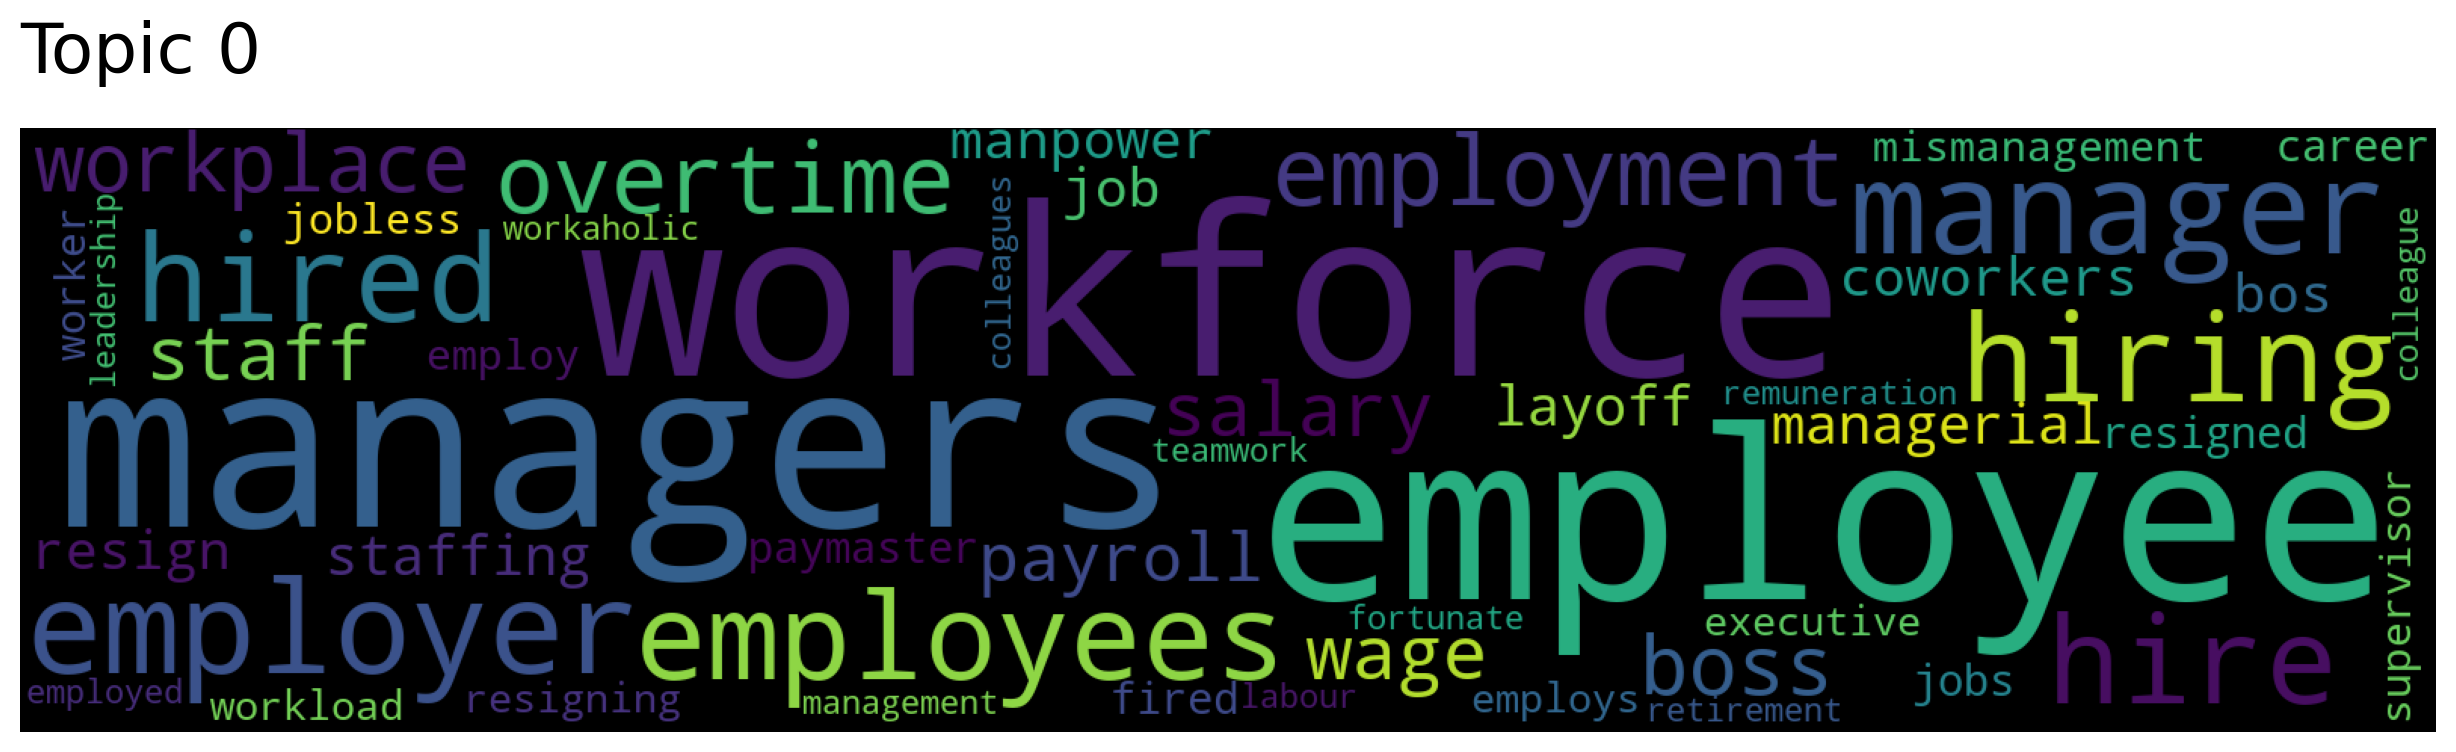

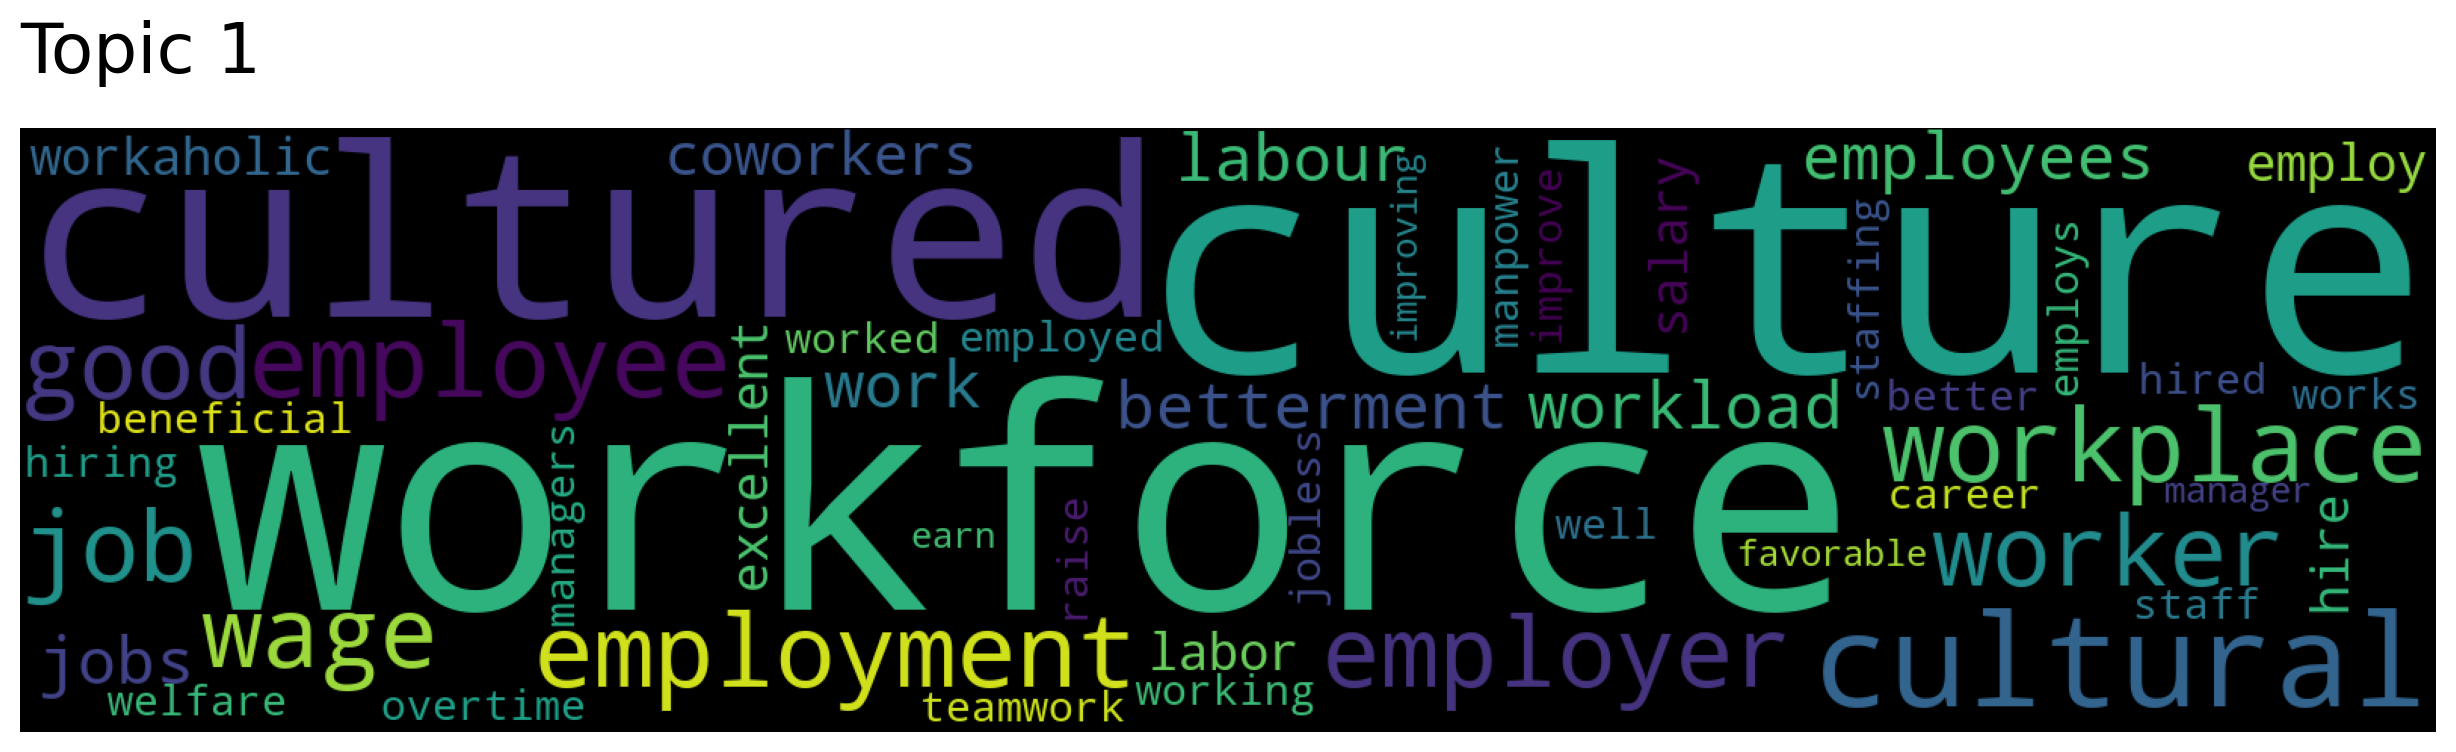

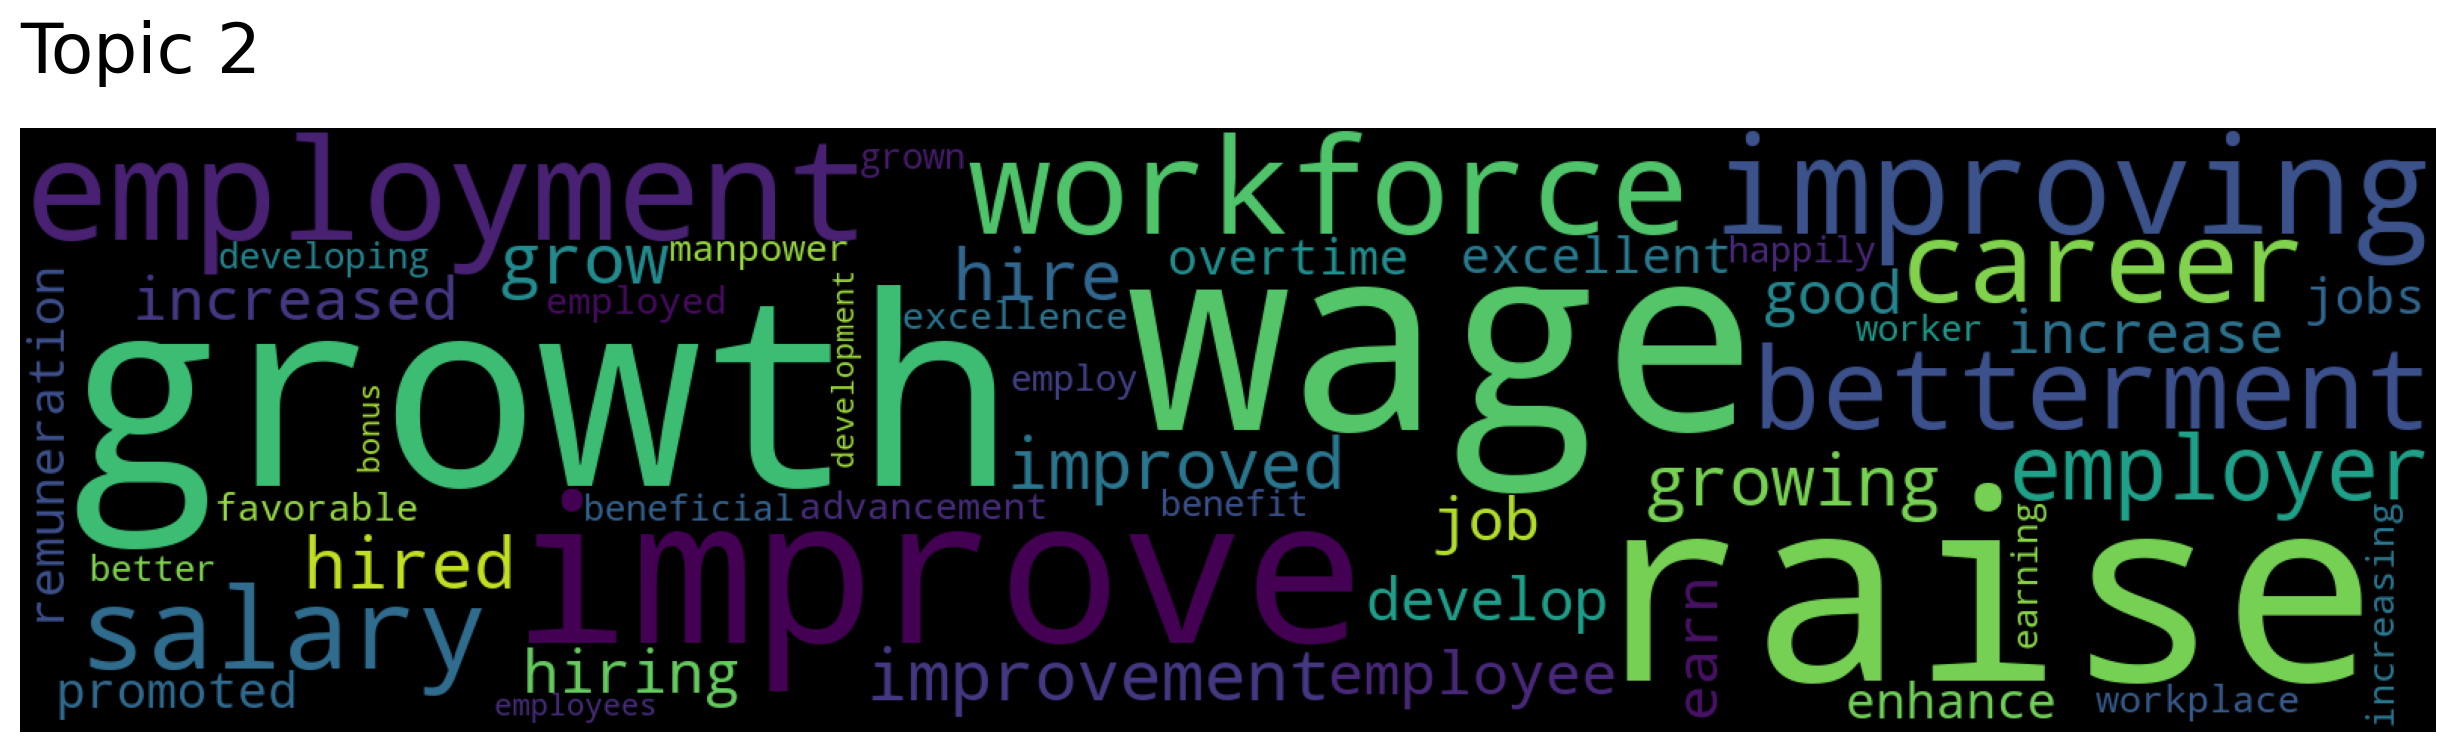

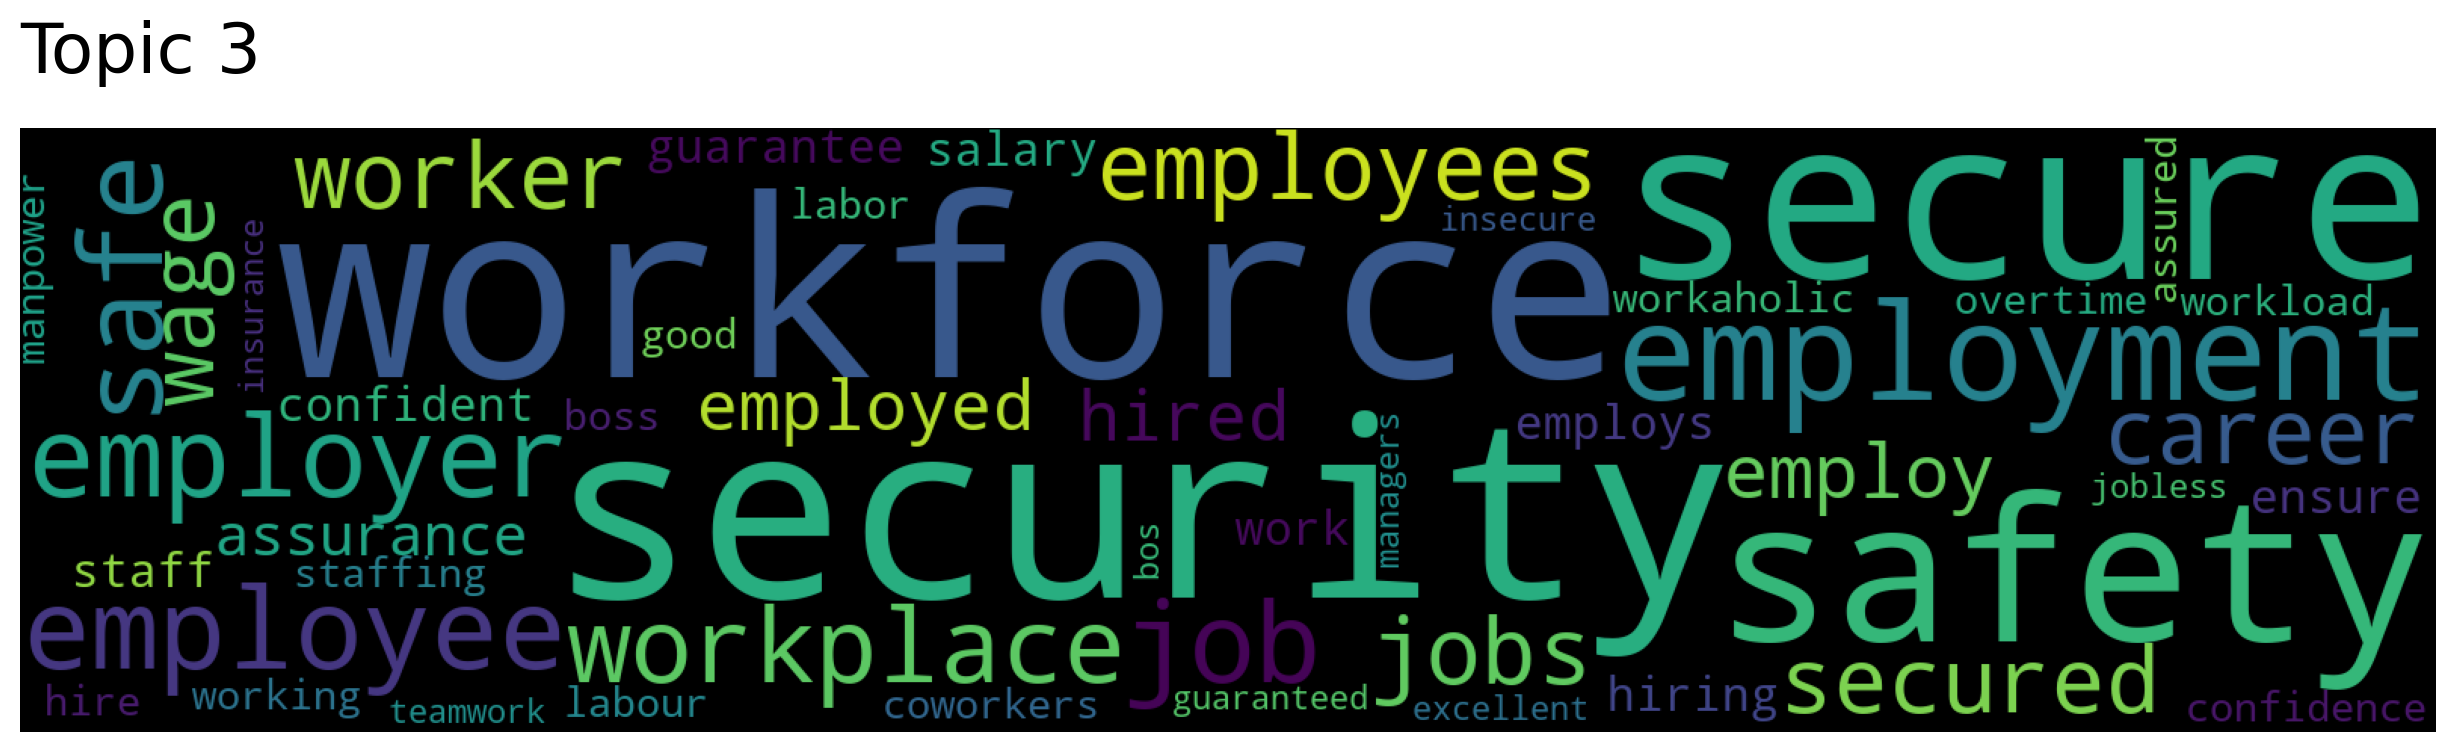

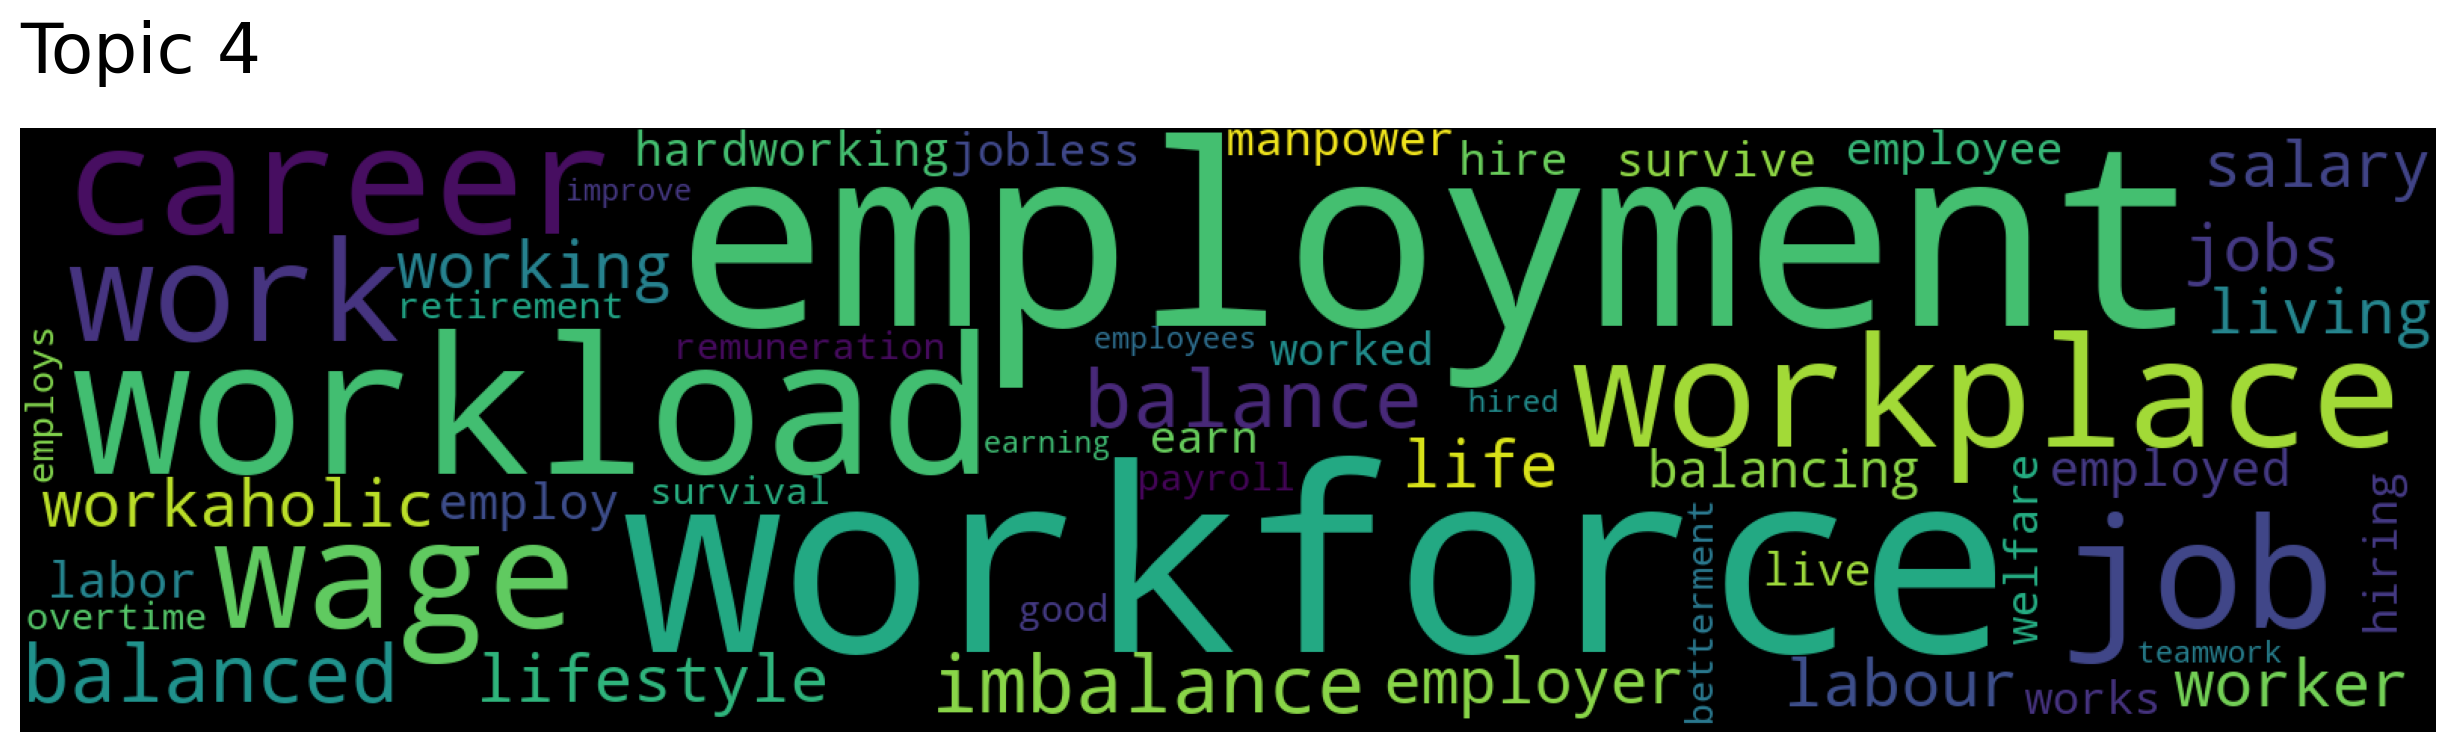

In [ ]:
topic_words, word_scores, topic_nums = model_reviews.get_topics(model_reviews.get_num_topics())
for topic in topic_nums[:5]:
    model_reviews.generate_topic_wordcloud(topic)

In [ ]:
documents, document_scores, document_ids = model_reviews.search_documents_by_topic(topic_num=1, num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 57586, Score: 0.8452590703964233
-----------
good work environment company culture good career growth ct c basic employee like c se a bm poor poor salary career growth slow lot politics
-----------

Document: 7966, Score: 0.8424749374389648
-----------
good work environment culture staff efficient supportive company give good salary bonus lot learn salary decent career growth slow
-----------

Document: 65195, Score: 0.842018723487854
-----------
good company work culture good lack op put unities career growth due biased management attitude
-----------

Document: 54386, Score: 0.8406109809875488
-----------
good work environment culture company policy good salary decent career growth slow
-----------

Document: 25501, Score: 0.8406109809875488
-----------
good work environment culture company policy good salary decent career growth slow
-----------



In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(reviews, show_progress_bar=True)

In [ ]:
len(embeddings)

87972

In [ ]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=10, 
                            n_components=10, 
                            metric='cosine').fit_transform(embeddings)

In [ ]:
embeddings.shape

(87972, 768)

In [ ]:
umap_embeddings.shape

(87972, 10)

In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

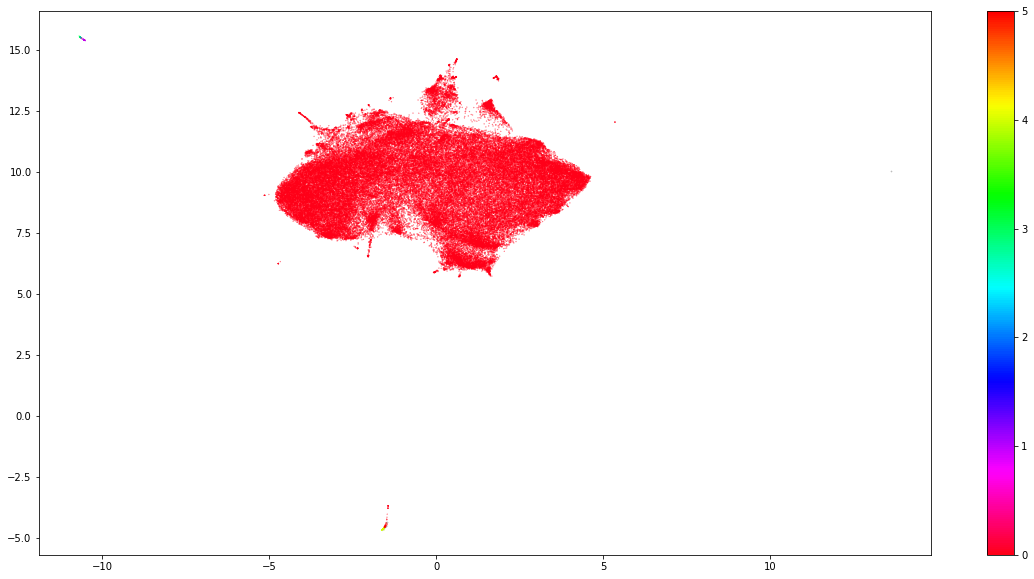

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [ ]:
docs_df = pd.DataFrame(reviews, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(reviews))

In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
1,0,87532
6,5,173
5,4,69
4,3,66
0,-1,52
2,1,48
3,2,32


In [ ]:
top_n_words[0]

[('employee', 0.015095924174841567),
 ('job', 0.014861297935120737),
 ('working', 0.014777505899556329),
 ('salary', 0.014709553373492284),
 ('growth', 0.014596765823224167),
 ('life', 0.013810648310205306),
 ('management', 0.013688961989470633),
 ('like', 0.013594787691422201),
 ('time', 0.013486843606506926),
 ('culture', 0.013242144425381481),
 ('team', 0.013091604073216526),
 ('environment', 0.01290800562371111),
 ('career', 0.012313398479824237),
 ('manager', 0.012296407311150271),
 ('security', 0.012264858876241985),
 ('balance', 0.012013580177714108),
 ('people', 0.011923838145701401),
 ('company', 0.011610875985989002),
 ('opportunity', 0.01159071942118484),
 ('thing', 0.011504958859041122)]

In [ ]:
top_n_words[1]

[('client', 0.12519536092228498),
 ('travel', 0.11656294330022815),
 ('canada', 0.10630422008827003),
 ('abroad', 0.09076206289048915),
 ('result', 0.07964749710008902),
 ('dependent', 0.0729077815795901),
 ('reliable', 0.07135105031864),
 ('especially', 0.07055587299560244),
 ('global', 0.06855688496906576),
 ('readily', 0.06829769392550832),
 ('fact', 0.06641258760834604),
 ('base', 0.06504698754836077),
 ('completely', 0.06470016511681519),
 ('adopts', 0.06328195093630835),
 ('high', 0.061025042898415864),
 ('innovation', 0.05977698225393929),
 ('latest', 0.05938477698282112),
 ('open', 0.05661694421041962),
 ('love', 0.05544636121120167),
 ('quality', 0.055360143502394016)]

In [ ]:
top_n_words[2]

[('client', 0.14247949393530457),
 ('step', 0.0837330101237345),
 ('travel', 0.07819439940267149),
 ('canada', 0.07611264277558365),
 ('midyear', 0.06465265807186214),
 ('unnoticed', 0.06140766382449206),
 ('email', 0.05701903761905377),
 ('dependent', 0.05623368083211853),
 ('receive', 0.05580056352571487),
 ('abroad', 0.05568809155349444),
 ('high', 0.05472380901765288),
 ('suggestion', 0.05422039736525034),
 ('unique', 0.05320325072355636),
 ('torn', 0.051561150502645044),
 ('folk', 0.0502078761876768),
 ('evening', 0.050130617629364174),
 ('completely', 0.0499031565100161),
 ('especially', 0.048285395862663186),
 ('attend', 0.04823787375855782),
 ('visa', 0.04778259064389663)]

In [ ]:
top_n_words[3]

[('client', 0.15092063806976905),
 ('step', 0.0960848859500259),
 ('travel', 0.07830916102954666),
 ('torn', 0.07100063296199785),
 ('canada', 0.06761837422161915),
 ('midyear', 0.06594657384381403),
 ('visa', 0.06579748797705086),
 ('quickly', 0.06231461942927078),
 ('abroad', 0.05898731163347131),
 ('unnoticed', 0.05831686838735032),
 ('folk', 0.05761429154591566),
 ('dependent', 0.05735910473136039),
 ('pain', 0.056144466343577684),
 ('email', 0.05608302987771363),
 ('receive', 0.05488455789650451),
 ('rehire', 0.05474179029659428),
 ('collaboration', 0.05430848693744611),
 ('happily', 0.05350899976999615),
 ('high', 0.052881172423153766),
 ('guide', 0.05209995516508385)]

In [ ]:
top_n_words[4]

[('arcade', 0.1132382686214733),
 ('gaming', 0.11206982429934359),
 ('chilling', 0.10645536780821988),
 ('bond', 0.10038977466774171),
 ('resign', 0.09549583674475273),
 ('cafeteria', 0.09510640715318616),
 ('fair', 0.09266183854110581),
 ('year', 0.0903506869698429),
 ('address', 0.08731809186314367),
 ('transparent', 0.08463476460256689),
 ('huge', 0.08448014769796085),
 ('ees', 0.07616634626739281),
 ('bonus', 0.07573723940271651),
 ('decent', 0.066221752375028),
 ('doesn', 0.0642629848138347),
 ('management', 0.06403577030716265),
 ('supportive', 0.06255118819557297),
 ('given', 0.061556178422651306),
 ('hike', 0.057942450283509056),
 ('slow', 0.05314323900545212)]

In [ ]:
top_n_words[5]

[('ees', 0.1149721695300216),
 ('arcade', 0.11212537371672918),
 ('chilling', 0.11189585058154058),
 ('gaming', 0.11096841275396556),
 ('bond', 0.10998663305688472),
 ('fair', 0.09739739247987285),
 ('resign', 0.09737991911973565),
 ('address', 0.09566534998972295),
 ('year', 0.09459790651808317),
 ('cafeteria', 0.0928264003044199),
 ('transparent', 0.08982783533582663),
 ('huge', 0.08614689635150806),
 ('bonus', 0.08384736466716615),
 ('doesn', 0.07658225588085137),
 ('decent', 0.07417039770916141),
 ('join', 0.07143134158900438),
 ('management', 0.067634096622136),
 ('issue', 0.06723781729480613),
 ('teammate', 0.06695638366076591),
 ('given', 0.0667560873307799)]

In [ ]:
top_n_words[-1]

[('client', 0.10739133767161305),
 ('travel', 0.0708544647414128),
 ('canada', 0.0705141501560993),
 ('torn', 0.05661978329672629),
 ('dependent', 0.05453768415611045),
 ('abroad', 0.05427658224699128),
 ('completely', 0.04839808719371132),
 ('visa', 0.046416221492128214),
 ('result', 0.04604230001461565),
 ('quickly', 0.04395926450316061),
 ('especially', 0.040786651062924804),
 ('base', 0.04066684477196331),
 ('collaboration', 0.040592159685484054),
 ('background', 0.039670510916134875),
 ('global', 0.039631084224110436),
 ('happily', 0.03938861489422343),
 ('reliable', 0.03925512207942462),
 ('location', 0.03906809517985743),
 ('readily', 0.038966936961865525),
 ('cultural', 0.038237057203747565)]